## Predictive Modeling of Cryptocurrency Prices
STA 208 - Spring 2021  
Group: Noah Perry

### Part 1: Data Processing

In [72]:
# Import and Clean Data
import os
os.chdir("C:/Users/noahj/Documents/UCD/2021 Spring Classes/STA 208/Project/STA208_FinalProject_NoahPerry")
exec(open("Code/01 Import and Clean.py").read())

ADA
start date: 2018-09-28 00:00:00
end date: 2021-03-31 00:00:00
------
ETH
start date: 2015-08-07 00:00:00
end date: 2021-03-31 00:00:00
------
XBT
start date: 2013-10-06 00:00:00
end date: 2021-03-31 00:00:00
------
XMR
start date: 2017-01-02 00:00:00
end date: 2021-03-31 00:00:00
------


*Notes:*
- The last quarterly data release included data up to March 31, 2021. I chose not to include more recent data in my analysis for this project.
- As seen in the output above, the date when each cryptocurrency was first listed on Kraken differs.
- Small number of missing values within each time series were filled by forward filling.


### Part 2: Exploratory Data Analysis and Feature Selection

**Topic 1: Price Variable to Use**  
The price used is daily price in USD. Unlike stock exchanges, cryptocurrency markets never close, so the daily price is simply a price recorded at 24-hour intervals. 

To deal with potential non-stationarity and heteroskedasticity in the prices, I used the log difference of price. I also tested whether forecasting the weekly or biweekly log difference of price is more effective than forecasting the daily log difference. The different variations of log differenced price are calculated as follows:
- Daily log difference of price: $log(\frac{Y_t}{Y_{t-1}}) = log(Y_t) - log(Y_{t-1})$
- Weekly log difference of price: $log(\frac{Y_t}{Y_{t-7}}) = log(Y_t) - log(Y_{t-7})$
- Biweekly log difference of price: $log(\frac{Y_t}{Y_{t-14}}) = log(Y_t) - log(Y_{t-14})$

A set of price charts for each of the four selected cryptocurrencies is shown below. For each cryptocurrency, the daily log differenced prices appears to be random noise around 0. However, for the weekly and biweekly log differenced prices, there is a more well-defined cyclical pattern. The charts for the weekly log differenced prices are omitted for conciseness as they resemble the charts of biweekly log differenced prices.

In [117]:
import matplotlib.pyplot as plt

main = pd.read_pickle("main.pkl")

# Levels and Log Difference Plots
def pr_plot(pr_type, shortname, longname, color_arg, lag = 0):
    if pr_type == "level":
        plt.plot(main["time"],main["pr_" + shortname], color = color_arg, label = longname)
        plt.title(longname + " Price (Levels, USD)")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.xticks(rotation = 60)  
    if pr_type == "logdif":
        if lag == 1:
            plt.plot(main["time"],main[pr_type + "_" + shortname], color = color_arg, label = longname)
            plt.title(longname + " Price (Daily Log Difference, USD)")
            plt.xlabel("Date")
            plt.ylabel("Log Difference")
            plt.xticks(rotation = 60)
        if lag == 14:
            plt.plot(main["time"],main[pr_type + str(lag) + "_" + shortname], color = color_arg, label = longname)
            plt.title(longname + " Price (Biweekly Log Difference, USD)")
            plt.xlabel("Date")
            plt.ylabel("Log Difference")
            plt.xticks(rotation = 60)

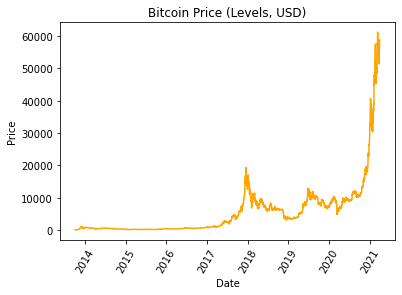

In [105]:
pr_plot("level",  "XBT", "Bitcoin",  "orange")

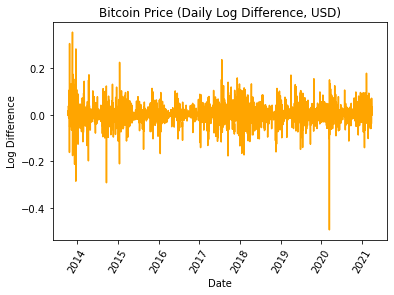

In [106]:
pr_plot("logdif", "XBT", "Bitcoin",  "orange", 1)

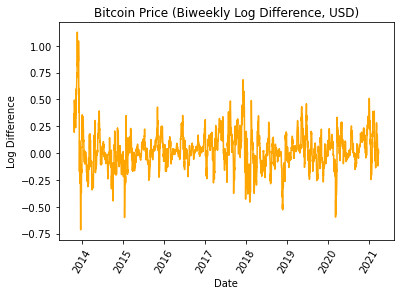

In [107]:
pr_plot("logdif", "XBT", "Bitcoin",  "orange", 14)

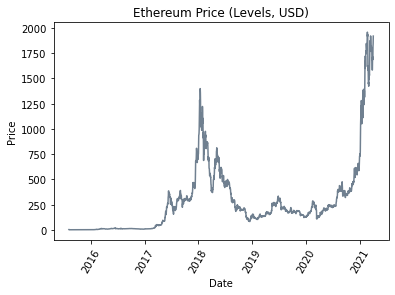

In [108]:
pr_plot("level",  "ETH", "Ethereum", "slategray")

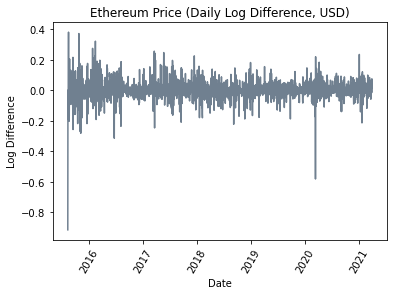

In [109]:
pr_plot("logdif", "ETH", "Ethereum", "slategray", 1)

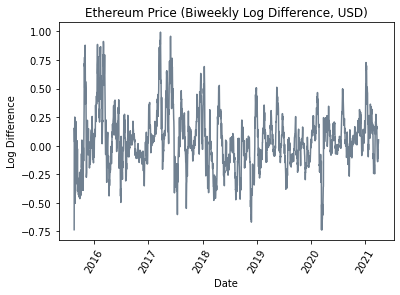

In [110]:
pr_plot("logdif", "ETH", "Ethereum", "slategray", 14)

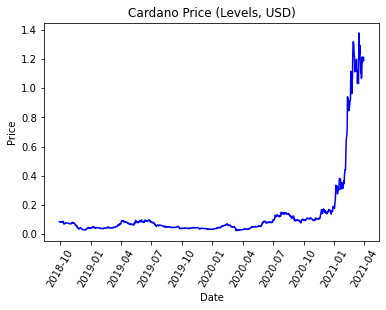

In [111]:
pr_plot("level",  "ADA", "Cardano",  "blue")

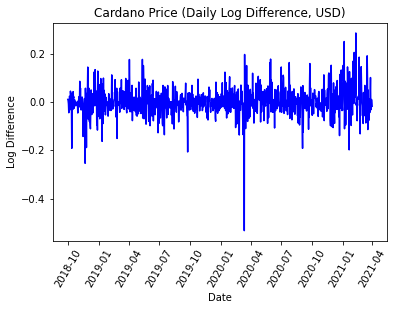

In [112]:
pr_plot("logdif", "ADA", "Cardano",  "blue", 1)

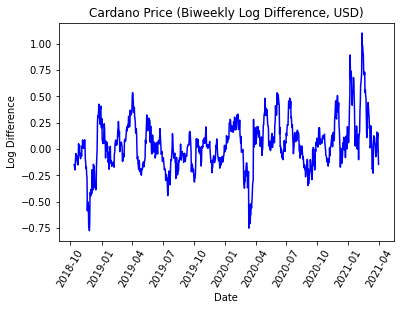

In [113]:
pr_plot("logdif", "ADA", "Cardano",  "blue", 14)

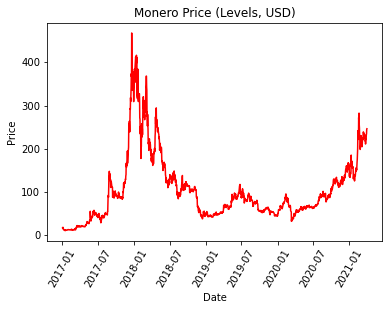

In [114]:
pr_plot("level",  "XMR", "Monero",   "red")

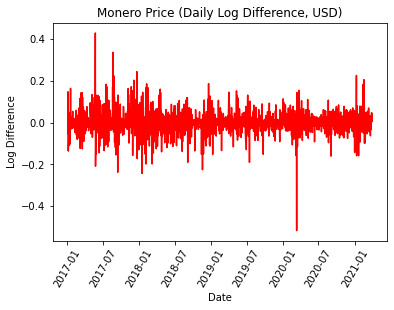

In [115]:
pr_plot("logdif", "XMR", "Monero",   "red", 1)

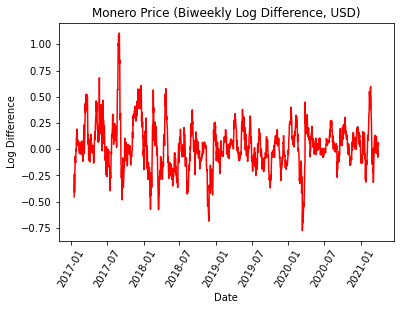

In [116]:
pr_plot("logdif", "XMR", "Monero",   "red", 14)

**Topic 2: Relationship between Cryptocurrency Prices**  
Since Bitcoin and Ethereum are the two most dominant coins in the cryptocurrency market, price movements of smaller coins tends to mirror the price movements in the two leader coins. The correlation tables show high positive correlations between the prices. The correlation between the log differenced prices is very similar regardless of whether daily, weekly, or biweekly log differenced price is used, so only the correlation table for biweekly log differenced price is shown.

In [86]:
# Pearson Correlations of Price in Levels
corrmat_level = main[["pr_XBT", "pr_ETH", "pr_ADA", "pr_XMR"]].corr(method = "pearson")
corrmat_level

,pr_XBT,pr_ETH,pr_ADA,pr_XMR
pr_XBT,1.000000,0.900212,0.927502,0.496109
pr_ETH,0.900212,1.000000,0.919624,0.754037
pr_ADA,0.927502,0.919624,1.000000,0.845838
pr_XMR,0.496109,0.754037,0.845838,1.000000


In [87]:
# Pearson Correlations of Biweekly Log Difference of Price
corrmat_logdif = main[["logdif14_XBT", "logdif14_ETH", "logdif14_ADA", "logdif14_XMR"]].corr(method = "pearson")
corrmat_logdif

,logdif14_XBT,logdif14_ETH,logdif14_ADA,logdif14_XMR
logdif14_XBT,1.000000,0.513236,0.697123,0.706511
logdif14_ETH,0.513236,1.000000,0.764176,0.695649
logdif14_ADA,0.697123,0.764176,1.000000,0.706000
logdif14_XMR,0.706511,0.695649,0.706000,1.000000


**Topic 3: Autocorrelation of Cryptocurrency Prices**  
The autocorrelation plots below show that for all four of the cryptocurrencies analyzed, there is basically no correlation between the daily log differenced price and its lags. However, the weekly and biweekly log differenced price charts show a more distinct cyclical pattern. For all four cryptocurrencies, the weekly and biweekly log differenced prices have a strong positive correlation with the initial lags.

In [118]:
# Autocorrelation Plots
def autocorr_plot(pr_type, shortname, longname, color_arg, lags):
    if lags == 1:
        pd.plotting.autocorrelation_plot(main[pr_type + "_" + shortname].dropna(), color = color_arg).set_xlim([0, 400])
        plt.title("Autocorrelation of " + longname + " Price (Daily Log Difference, USD)")
    if lags == 7:
        pd.plotting.autocorrelation_plot(main[pr_type + str(lags) + "_" + shortname].dropna(), color = color_arg).set_xlim([0, 400])
        plt.title("Autocorrelation of " + longname + " Price (Weekly Log Difference, USD)")
    if lags == 14:
        pd.plotting.autocorrelation_plot(main[pr_type + str(lags) + "_" + shortname].dropna(), color = color_arg).set_xlim([0, 400])
        plt.title("Autocorrelation of " + longname + " Price (Biweekly Log Difference, USD)")

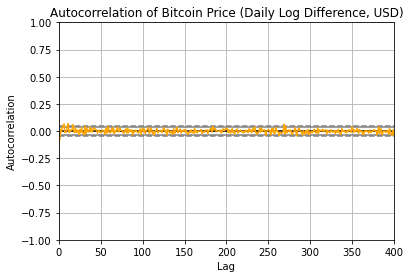

In [119]:
autocorr_plot("logdif", "XBT", "Bitcoin",  "orange", 1)

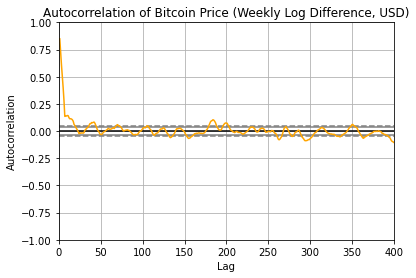

In [120]:
autocorr_plot("logdif", "XBT", "Bitcoin",  "orange", 7)

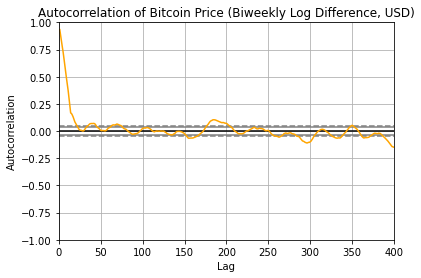

In [121]:
autocorr_plot("logdif", "XBT", "Bitcoin",  "orange", 14)

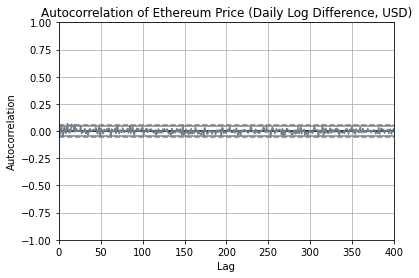

In [122]:
autocorr_plot("logdif", "ETH", "Ethereum", "slategray", 1)

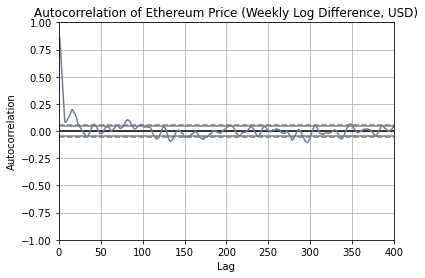

In [123]:
autocorr_plot("logdif", "ETH", "Ethereum", "slategray", 7)

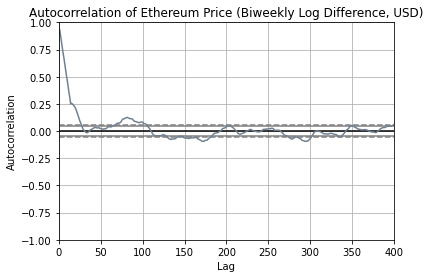

In [124]:
autocorr_plot("logdif", "ETH", "Ethereum", "slategray", 14)

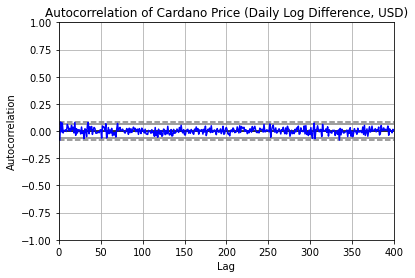

In [125]:
autocorr_plot("logdif", "ADA", "Cardano",  "blue", 1)

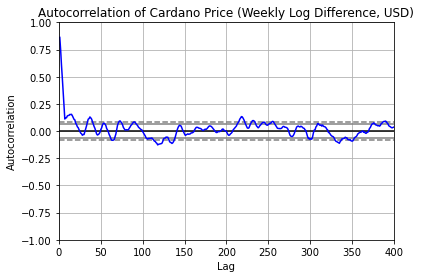

In [126]:
autocorr_plot("logdif", "ADA", "Cardano",  "blue", 7)

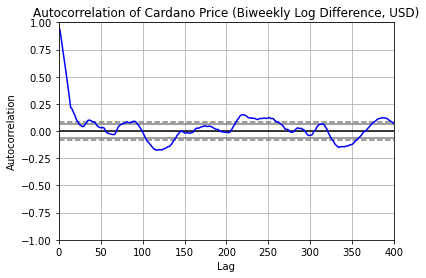

In [127]:
autocorr_plot("logdif", "ADA", "Cardano",  "blue", 14)

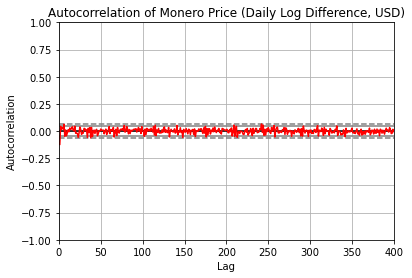

In [128]:
autocorr_plot("logdif", "XMR", "Monero",   "red", 1)

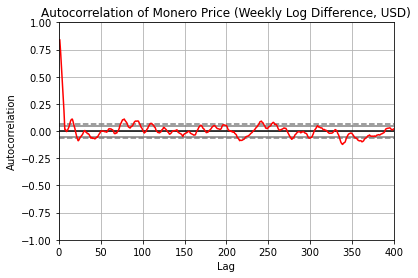

In [129]:
autocorr_plot("logdif", "XMR", "Monero",   "red", 7)

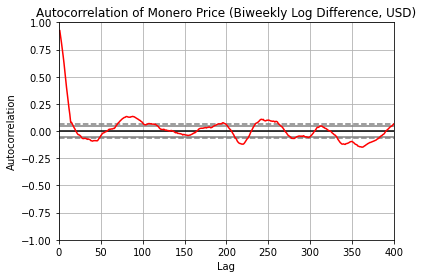

In [130]:
autocorr_plot("logdif", "XMR", "Monero",   "red", 14)

**Conclusions about Feature Selection**   
- I will use daily log differenced price, weekly log differenced price, and biweekly log differenced price as my target variables.
- Due to the autocorrelation between the log differenced prices and lags of the log differenced prices, I include lags of the log differenced prices in my models. Based on the autocorrelation plot, I test as many as 30 lags in the vector autoregressions.
- Due to the high positive correlation between cryptocurrencies, I use lags of Bitcoin and Ethereum prices as features in my models.